In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [3]:
dataset = load_dataset("imdb")

def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Small subset for faster run
train_data = tokenized_dataset["train"].shuffle(seed=42).select(range(400))
train_loader = DataLoader(train_data, batch_size=8)


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
optimizer = AdamW(model.parameters(), lr=2e-5)


In [5]:
model.train()

loss_list = []
accuracy_list = []
step_list = []

correct = 0
total = 0
total_steps = 0

for epoch in range(1):
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        total_steps += 1

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accuracy calculation
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        acc = correct / total

        # Logging
        loss_list.append(loss.item())
        accuracy_list.append(acc)
        step_list.append(total_steps)

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item(), acc=acc)

        print(f"[Step {total_steps}] Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1:   2%|▏         | 1/50 [00:20<16:51, 20.65s/it, acc=0.5, loss=0.721]

[Step 1] Loss: 0.7206 | Accuracy: 0.5000


Epoch 1:   4%|▍         | 2/50 [00:35<13:50, 17.31s/it, acc=0.5, loss=0.709]

[Step 2] Loss: 0.7094 | Accuracy: 0.5000


Epoch 1:   6%|▌         | 3/50 [00:50<12:41, 16.20s/it, acc=0.458, loss=0.739]

[Step 3] Loss: 0.7394 | Accuracy: 0.4583


Epoch 1:   8%|▊         | 4/50 [01:04<11:51, 15.46s/it, acc=0.5, loss=0.652]

[Step 4] Loss: 0.6520 | Accuracy: 0.5000


Epoch 1:  10%|█         | 5/50 [01:19<11:18, 15.08s/it, acc=0.525, loss=0.702]

[Step 5] Loss: 0.7019 | Accuracy: 0.5250


Epoch 1:  12%|█▏        | 6/50 [01:33<10:52, 14.83s/it, acc=0.542, loss=0.657]

[Step 6] Loss: 0.6567 | Accuracy: 0.5417


Epoch 1:  14%|█▍        | 7/50 [01:47<10:31, 14.69s/it, acc=0.571, loss=0.672]

[Step 7] Loss: 0.6716 | Accuracy: 0.5714


Epoch 1:  16%|█▌        | 8/50 [02:02<10:13, 14.61s/it, acc=0.594, loss=0.667]

[Step 8] Loss: 0.6668 | Accuracy: 0.5938


Epoch 1:  18%|█▊        | 9/50 [02:16<09:55, 14.52s/it, acc=0.583, loss=0.687]

[Step 9] Loss: 0.6869 | Accuracy: 0.5833


Epoch 1:  20%|██        | 10/50 [02:31<09:38, 14.47s/it, acc=0.588, loss=0.664]

[Step 10] Loss: 0.6637 | Accuracy: 0.5875


Epoch 1:  22%|██▏       | 11/50 [02:45<09:22, 14.42s/it, acc=0.58, loss=0.7]

[Step 11] Loss: 0.7003 | Accuracy: 0.5795


Epoch 1:  24%|██▍       | 12/50 [02:59<09:06, 14.38s/it, acc=0.562, loss=0.857]

[Step 12] Loss: 0.8571 | Accuracy: 0.5625


Epoch 1:  26%|██▌       | 13/50 [03:14<08:51, 14.36s/it, acc=0.577, loss=0.689]

[Step 13] Loss: 0.6893 | Accuracy: 0.5769


Epoch 1:  28%|██▊       | 14/50 [03:28<08:38, 14.41s/it, acc=0.58, loss=0.666]

[Step 14] Loss: 0.6661 | Accuracy: 0.5804


Epoch 1:  30%|███       | 15/50 [03:42<08:24, 14.41s/it, acc=0.575, loss=0.726]

[Step 15] Loss: 0.7256 | Accuracy: 0.5750


Epoch 1:  32%|███▏      | 16/50 [03:57<08:09, 14.40s/it, acc=0.555, loss=0.737]

[Step 16] Loss: 0.7368 | Accuracy: 0.5547


Epoch 1:  34%|███▍      | 17/50 [04:11<07:52, 14.32s/it, acc=0.559, loss=0.64]

[Step 17] Loss: 0.6404 | Accuracy: 0.5588


Epoch 1:  36%|███▌      | 18/50 [04:25<07:37, 14.28s/it, acc=0.562, loss=0.665]

[Step 18] Loss: 0.6655 | Accuracy: 0.5625


Epoch 1:  38%|███▊      | 19/50 [04:39<07:22, 14.29s/it, acc=0.579, loss=0.615]

[Step 19] Loss: 0.6152 | Accuracy: 0.5789


Epoch 1:  40%|████      | 20/50 [04:54<07:09, 14.31s/it, acc=0.575, loss=0.69]

[Step 20] Loss: 0.6903 | Accuracy: 0.5750


Epoch 1:  42%|████▏     | 21/50 [05:08<06:56, 14.35s/it, acc=0.571, loss=0.661]

[Step 21] Loss: 0.6607 | Accuracy: 0.5714


Epoch 1:  44%|████▍     | 22/50 [05:25<07:04, 15.15s/it, acc=0.58, loss=0.616]

[Step 22] Loss: 0.6159 | Accuracy: 0.5795


Epoch 1:  46%|████▌     | 23/50 [05:40<06:47, 15.11s/it, acc=0.56, loss=0.827]

[Step 23] Loss: 0.8269 | Accuracy: 0.5598


Epoch 1:  48%|████▊     | 24/50 [05:55<06:28, 14.93s/it, acc=0.557, loss=0.702]

[Step 24] Loss: 0.7017 | Accuracy: 0.5573


Epoch 1:  50%|█████     | 25/50 [06:09<06:08, 14.72s/it, acc=0.545, loss=0.763]

[Step 25] Loss: 0.7628 | Accuracy: 0.5450


Epoch 1:  52%|█████▏    | 26/50 [06:24<05:51, 14.66s/it, acc=0.553, loss=0.646]

[Step 26] Loss: 0.6456 | Accuracy: 0.5529


Epoch 1:  54%|█████▍    | 27/50 [06:38<05:35, 14.58s/it, acc=0.56, loss=0.661]

[Step 27] Loss: 0.6615 | Accuracy: 0.5602


Epoch 1:  56%|█████▌    | 28/50 [06:52<05:18, 14.50s/it, acc=0.562, loss=0.643]

[Step 28] Loss: 0.6426 | Accuracy: 0.5625


Epoch 1:  58%|█████▊    | 29/50 [07:07<05:03, 14.46s/it, acc=0.56, loss=0.723]

[Step 29] Loss: 0.7233 | Accuracy: 0.5603


Epoch 1:  60%|██████    | 30/50 [07:21<04:48, 14.44s/it, acc=0.562, loss=0.66]

[Step 30] Loss: 0.6599 | Accuracy: 0.5625


Epoch 1:  62%|██████▏   | 31/50 [07:35<04:33, 14.40s/it, acc=0.569, loss=0.595]

[Step 31] Loss: 0.5947 | Accuracy: 0.5685


Epoch 1:  64%|██████▍   | 32/50 [07:50<04:19, 14.40s/it, acc=0.566, loss=0.662]

[Step 32] Loss: 0.6622 | Accuracy: 0.5664


Epoch 1:  66%|██████▌   | 33/50 [08:04<04:03, 14.32s/it, acc=0.568, loss=0.65]

[Step 33] Loss: 0.6497 | Accuracy: 0.5682


Epoch 1:  68%|██████▊   | 34/50 [08:18<03:48, 14.30s/it, acc=0.57, loss=0.614]

[Step 34] Loss: 0.6145 | Accuracy: 0.5699


Epoch 1:  70%|███████   | 35/50 [08:32<03:33, 14.24s/it, acc=0.575, loss=0.619]

[Step 35] Loss: 0.6187 | Accuracy: 0.5750


Epoch 1:  72%|███████▏  | 36/50 [08:47<03:20, 14.32s/it, acc=0.573, loss=0.692]

[Step 36] Loss: 0.6917 | Accuracy: 0.5729


Epoch 1:  74%|███████▍  | 37/50 [09:01<03:06, 14.37s/it, acc=0.571, loss=0.681]

[Step 37] Loss: 0.6812 | Accuracy: 0.5709


Epoch 1:  76%|███████▌  | 38/50 [09:16<02:52, 14.36s/it, acc=0.569, loss=0.691]

[Step 38] Loss: 0.6910 | Accuracy: 0.5691


Epoch 1:  78%|███████▊  | 39/50 [09:30<02:38, 14.38s/it, acc=0.574, loss=0.611]

[Step 39] Loss: 0.6107 | Accuracy: 0.5737


Epoch 1:  80%|████████  | 40/50 [09:44<02:23, 14.40s/it, acc=0.569, loss=0.756]

[Step 40] Loss: 0.7562 | Accuracy: 0.5687


Epoch 1:  82%|████████▏ | 41/50 [09:59<02:09, 14.44s/it, acc=0.561, loss=0.924]

[Step 41] Loss: 0.9242 | Accuracy: 0.5610


Epoch 1:  84%|████████▍ | 42/50 [10:13<01:55, 14.47s/it, acc=0.56, loss=0.638]

[Step 42] Loss: 0.6381 | Accuracy: 0.5595


Epoch 1:  86%|████████▌ | 43/50 [10:28<01:41, 14.47s/it, acc=0.558, loss=0.687]

[Step 43] Loss: 0.6872 | Accuracy: 0.5581


Epoch 1:  88%|████████▊ | 44/50 [10:42<01:26, 14.45s/it, acc=0.557, loss=0.682]

[Step 44] Loss: 0.6816 | Accuracy: 0.5568


Epoch 1:  90%|█████████ | 45/50 [10:57<01:12, 14.46s/it, acc=0.558, loss=0.626]

[Step 45] Loss: 0.6265 | Accuracy: 0.5583


Epoch 1:  92%|█████████▏| 46/50 [11:11<00:57, 14.42s/it, acc=0.557, loss=0.674]

[Step 46] Loss: 0.6741 | Accuracy: 0.5571


Epoch 1:  94%|█████████▍| 47/50 [11:26<00:43, 14.39s/it, acc=0.553, loss=0.723]

[Step 47] Loss: 0.7233 | Accuracy: 0.5532


Epoch 1:  96%|█████████▌| 48/50 [11:40<00:28, 14.36s/it, acc=0.56, loss=0.541]

[Step 48] Loss: 0.5412 | Accuracy: 0.5599


Epoch 1:  98%|█████████▊| 49/50 [11:54<00:14, 14.37s/it, acc=0.569, loss=0.609]

[Step 49] Loss: 0.6091 | Accuracy: 0.5689


Epoch 1: 100%|██████████| 50/50 [12:09<00:00, 14.58s/it, acc=0.568, loss=0.698]

[Step 50] Loss: 0.6984 | Accuracy: 0.5675


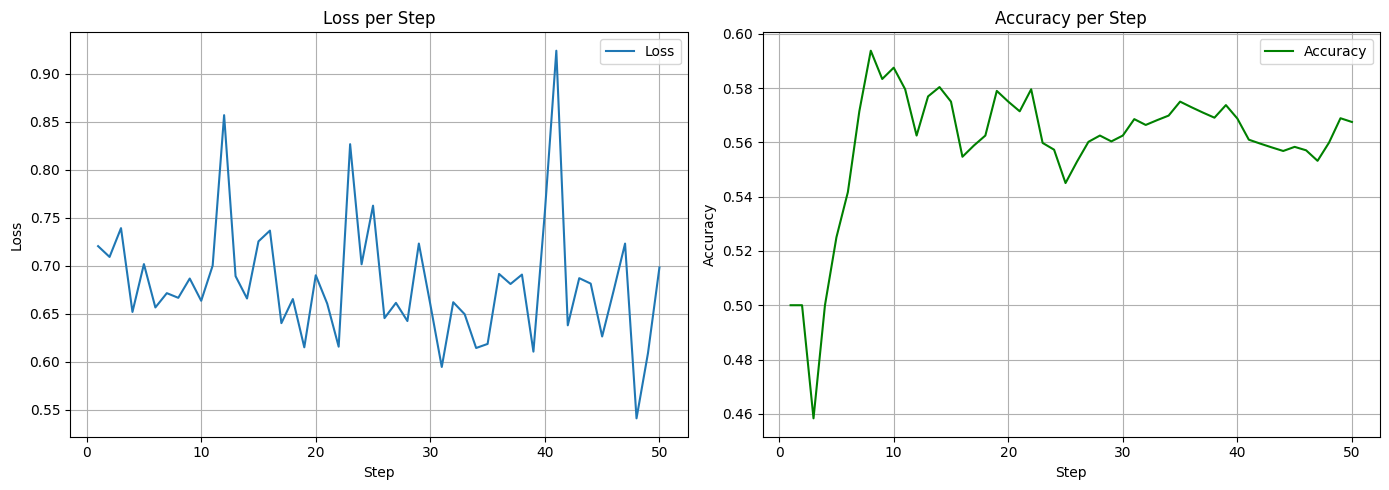

In [6]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(step_list, loss_list, label="Loss")
plt.title("Loss per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(step_list, accuracy_list, label="Accuracy", color='green')
plt.title("Accuracy per Step")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
